In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table
from astropy.table import Table
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier
from astroquery.mast import Catalogs
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import os
from os import walk
import pyvo

# Dias cluster tables
* Create cluster member tables using FTP
* Cross match with NSS to create candidate pool
* Query cluster parameters from Vizier

In [19]:
clusters = pd.read_csv('data/hunt_clusters/clusters.csv')
memb = pd.read_csv('data/hunt_clusters/members.csv')

cut = (clusters['cst']>5) & (clusters['class_50']>0.5)
clusters = clusters[cut]
memb = memb[np.isin(memb['id'], clusters['id'])]

In [ ]:
count = 0 
for id in tqdm(np.unique(memb['id']),total=len(np.unique(memb['id']))):
    clstr_memb = memb[memb['id'] == id]
    tap_service = pyvo.dal.TAPService("http://dc.zah.uni-heidelberg.de/tap")
    query = f"""SELECT source_id, fidelity_v2 FROM gedr3spur.main WHERE source_id IN {tuple(clstr_memb['source_id'].values)}"""
    result = tap_service.search(query).to_table()
    clstr_memb = table.join(Table.from_pandas(clstr_memb), result, keys='source_id')
    cut = (clstr_memb['fidelity_v2'] > 0.5) & (clstr_memb['parallax']/clstr_memb['parallax_error'] > 10) & (clstr_memb['probability'] > 0.9)
    count += np.count_nonzero(cut)


In [ ]:
## Constructing Dias cluster member tables using FTP/Vizier

from ftplib import FTP

clusters = Vizier(catalog='J/MNRAS/504/356',columns=['Cluster','N','logage','e_loagage','[Fe/H]','e_[Fe/H]','Av','e_Av','FileName'],row_limit=-1).query_constraints()[0]

cut1 = [fname.startswith('clusters1') for fname in clusters['FileName']]
cut2 = [fname.startswith('clusters2') for fname in clusters['FileName']]

ftp = FTP('cdsarc.u-strasbg.fr')
ftp.login()
ftp.cwd('pub/cats/J/MNRAS/504/356/clusters1')
count = 0
nss_count = 0
for fname in tqdm(clusters[cut2]['FileName'],total=len(clusters[cut1])):
    dirname,fname = fname.split('/') 
    with open(os.path.join('data','clusters',fname), 'wb') as f:
        ftp.retrbinary('RETR ' + fname, f.write)
    if dirname == 'clusters1':
        new_names= [
            "pmRApmDEcor",
            "PlxpmRAcor",
            "PlxpmDEcor",
            "RFG",
            "RFBP",
            "RFRP",
            "E(BR/RP)",
            "Nper",
            "[Fe/H]temp",
            "RAdeg",
            "e_RAdeg",
            "DEdeg",
            "e_DEdeg",
            "Source",
            "Plx",
            "e_Plx",
            "pmRA",
            "e_pmRA",
            "pmDE",
            "e_pmDE",
            "Dup",
            "FG",
            "e_FG",
            "Gmag",
            "e_Gmag",
            "FBP",
            "e_FBP",
            "BPmag",
            "e_BPmag",
            "FRP",
            "e_FRP",
            "RPmag",
            "e_RPmag",
            "BP-RP",
            "RV",
            "e_RV",
            "Teff",
            "AG",
            "E(BR-RP)",
            "Rad",
            "Lum",
            "Pmemb",
            "Cluster"
        ]
    elif dirname == 'clusters2':
        new_names = [
            "pmRApmDEcor",
            "PlxpmRAcor",
            "PlxpmDEcor",
            "RFG",
            "RFBP",
            "RFRP",
            "E(BR/RP)",
            "Nper",
            "RAdeg",
            "e_RAdeg",
            "DEdeg",
            "e_DEdeg",
            "Source",
            "Plx",
            "e_Plx",
            "pmRA",
            "e_pmRA",
            "pmDE",
            "e_pmDE",
            "Dup",
            "FG",
            "e_FG",
            "Gmag",
            "e_Gmag",
            "FBP",
            "e_FBP",
            "BPmag",
            "e_BPmag",
            "FRP",
            "e_FRP",
            "RPmag",
            "e_RPmag",
            "BP-RP",
            "RV",
            "e_RV",
            "Teff",
            "AG",
            "E(BR-RP)",
            "Rad",
            "Lum",
            "Pmemb"
        ]
    memb = pd.read_fwf(os.path.join('data','clusters',fname),header=None)
    if memb.shape[1] != len(new_names):
        continue
    memb.columns = new_names
    memb = Table.from_pandas(memb)
    memb.keep_columns(['Source','Pmemb','Plx','e_Plx'])
    cname = fname.split('.')[0]
    os.remove(os.path.join('data','clusters',fname))

    tap_service = pyvo.dal.TAPService("http://dc.g-vo.org/tap")
    query = f'''SELECT source_id, fidelity_v2 FROM gedr3spur.main WHERE source_id IN {tuple(memb['Source'].data)}'''
    result = tap_service.search(query).to_table()
    memb = table.join(memb,result,keys_left='Source',keys_right='source_id')
    if len(memb) > 1:
        query = '''SELECT source_id,parallax,parallax_error FROM gaiadr3.gaia_source WHERE source_id IN {id_lst}'''.format(id_lst = tuple(memb['Source'].data))
        job = Gaia.launch_job(query= query)
        memb1 = job.get_results()
        if 'SOURCE_ID' in memb1.colnames:
            memb1.rename_column('SOURCE_ID','source_id')
        memb.rename_column('Source','source_id')
        memb = table.join(memb,memb1,keys='source_id',join_type='inner')
    else:
        memb.rename_column('Plx','parallax')
        memb.rename_column('e_Plx','parallax_error')
    cut = memb['parallax']/memb['parallax_error'] > 10
    # memb = memb[memb['Pmemb'] >= 0.8]
    # if len(memb) > 1:
    #     query = '''SELECT source_id, ra , dec, ra_error ,dec_error,parallax,parallax_error, ruwe, phot_g_mean_flux, phot_g_mean_flux_error, phot_g_mean_mag,
    #     phot_g_mean_flux_over_error, phot_bp_mean_flux, phot_bp_mean_flux_error, phot_bp_mean_flux_over_error, phot_bp_mean_mag, phot_rp_mean_flux,
    #         phot_rp_mean_flux_error, phot_rp_mean_flux_over_error, phot_rp_mean_mag, bp_rp, bp_g, g_rp, radial_velocity, radial_velocity_error, l, b,
    #         has_xp_sampled, has_rvs, has_epoch_photometry, has_epoch_rv, non_single_star, pmra, pmra_error, pmdec, pmdec_error
    #         FROM gaiadr3.gaia_source
    #         WHERE source_id IN {id_lst}
    #         '''.format(id_lst = tuple(memb['Source'].data))
    #     job = Gaia.launch_job(query= query)
    #     memb1 = job.get_results()
    #     if 'SOURCE_ID' in memb1.colnames:
    #         memb1.rename_column('SOURCE_ID','source_id')
    #     memb.rename_column('Source','source_id')
    #     memb = table.join(memb,memb1,keys='source_id',join_type='inner')
    #     cut = memb['parallax']/memb['parallax_error'] > 10
    #     memb = memb[cut]
    #     nss_count += np.count_nonzero(memb['non_single_star'] > 0)
        # memb.write(os.path.join('data','clusters2',cname + '.fits'),format='fits',overwrite=True)
ftp.quit()


 38%|███▊      | 478/1265 [10:44<17:40,  1.35s/it]


'221 Goodbye.'

In [2]:
## Creating a NSS table from Dias cluster members



basedir = './data/clusters2/'
filenames = next(walk(basedir), (None, None, []))[2]
# filenames.remove('cluster_ages.fits')
# filenames.remove('cluster_ages.dat')

clstr_lst = []
id_lst = []
pmemb_lst = []
for f in tqdm(filenames):
    if f.endswith('.dat'):
        continue
    clstrname = f.split('.')[0]
    tbl = Table.read(os.path.join(basedir,f), format='fits')
    tbl = tbl[tbl['non_single_star'] > 0]
    clstr_lst.extend(np.full(len(tbl), clstrname))
    id_lst.extend(tbl['source_id'].data)
    pmemb_lst.extend(tbl['Pmemb'].data)
table_0 = Table({'source_id': id_lst, 'cluster': clstr_lst, 'Pmemb': pmemb_lst})

100%|██████████| 1550/1550 [00:37<00:00, 41.48it/s]


In [ ]:
## Adding cluster ages, metallicities and extinctions to the NSS table
 
# clusters = Vizier(catalog='J/MNRAS/504/356',columns=['Cluster','N','logage','e_logage','[Fe/H]','e_[Fe/H]','Av','e_Av','FileName'],row_limit=-1).query_constraints()[0]

# clusters.rename_columns(clusters.colnames,['Cluster','N','logage','e_logage','Fe/H','e_Fe/H','Av','e_Av','FileName'])

# table_0['age'] = np.full(len(table_0),np.nan)
# table_0['age_err'] = np.full(len(table_0),np.nan)
# table_0['mh_for_mass_interp'] = np.full(len(table_0),np.nan)
# table_0['mh_err'] = np.full(len(table_0),np.nan)
# table_0['av_for_mass_interp'] = np.full(len(table_0),np.nan)
# table_0['av_err'] = np.full(len(table_0),np.nan)

# for i in range(len(table_0)):
#     cname = table_0[i]['cluster']
#     if cname not in clusters['Cluster']:
#         continue
#     age = 10**clusters[clusters['Cluster'] == cname]['logage']*1e-6
#     age_err = clusters[clusters['Cluster'] == cname]['e_logage'][0] * age / np.log(10)
#     feh = clusters[clusters['Cluster'] == cname]['Fe/H'][0]
#     feh_err = clusters[clusters['Cluster'] == cname]['e_Fe/H'][0]
#     av = clusters[clusters['Cluster'] == cname]['Av'][0]
#     av_err = clusters[clusters['Cluster'] == cname]['e_Av'][0]

#     table_0[i]['age'] = age
#     table_0[i]['age_err'] = age_err
#     table_0[i]['mh_for_mass_interp'] = feh
#     table_0[i]['mh_err'] = feh_err
#     table_0[i]['av_for_mass_interp'] = av
#     table_0[i]['av_err'] = av_err
    

# Hunt cluster table
* Cross match Hunt and NSS
* Apply cuts to the tables (membership prob,parallax over error, cluster reliability)
* Rename columns for compatibility with Dias

In [7]:
# Load hunt tables, apply cuts, 

members = Table.from_pandas(pd.read_csv('./data/hunt_clusters/members.csv',usecols=['source_id','name','probability','non_single_star','parallax','parallax_error']))
clusters = Table.from_pandas(pd.read_csv('./data/hunt_clusters/clusters.csv',usecols=['name','cst','class_50']))

cut = (clusters['cst'] > 5) & (clusters['class_50'] > 0.5)
clusters = clusters[cut]
members = members[np.isin(members['name'],clusters['name'])]
cut1 = members['non_single_star'] > 0
cut2 = members['probability'] >= 0.8
cut3 = members['parallax']/members['parallax_error'] > 10
cut = cut1 & cut2 & cut3
members = members[cut]
members.keep_columns(['source_id','name','probability'])
members.rename_columns(['name','probability'],['cluster','Pmemb'])
table_0 = members.copy()
# table_0 = table.join(table_0, members, keys='source_id', join_type='left')
# table_0 = table.join(table_0, clusters, keys='id', join_type='left')

# Gaia and NSS parameters
* Add Gaia/NSS parameters to the candidate table
* table_A cuts:
    - parallax/error > 10
    - astrometric fidelity > 0.5
    - Pmemb >=0.9
    - nss_solution_type: 'orbital'/'astrospectroSB1'
    - nss cuts on eccentricity error, significance, parallax over error

In [3]:
## query gaia for all sources in table_0- get relevant columns

query1 = '''SELECT source_id, ra , dec, ra_error ,dec_error,parallax,parallax_error, astrometric_excess_noise, astrometric_excess_noise_sig,
 astrometric_params_solved, pseudocolour, visibility_periods_used, astrometric_sigma5d_max, ruwe, phot_g_mean_flux, phot_g_mean_flux_error, phot_g_mean_mag,
   phot_g_mean_flux_over_error, phot_bp_mean_flux, phot_bp_mean_flux_error, phot_bp_mean_flux_over_error, phot_bp_mean_mag, phot_rp_mean_flux,
     phot_rp_mean_flux_error, phot_rp_mean_flux_over_error, phot_rp_mean_mag, bp_rp, bp_g, g_rp, radial_velocity, radial_velocity_error, l, b,
       ecl_lon, ecl_lat, has_xp_continuous, has_xp_sampled, has_rvs, has_epoch_photometry, has_epoch_rv, non_single_star, pmra, pmra_error, pmdec, pmdec_error
    FROM gaiadr3.gaia_source
    WHERE source_id IN {id_lst}
    '''.format(id_lst = tuple(table_0['source_id'].data))
job1 = Gaia.launch_job(query= query1)
table_1 = job1.get_results()
if 'SOURCE_ID' in table_1.colnames:
    table_1.rename_column('SOURCE_ID','source_id')

table_1 = table.join(table_0,table_1,keys=['source_id'],join_type='left')

## query nss for all soruces in table_0 - get relevant columns

query2 = '''SELECT source_id, parallax, parallax_error , pmra, pmra_error,
 pmdec, pmdec_error, a_thiele_innes, a_thiele_innes_error, b_thiele_innes, b_thiele_innes_error, f_thiele_innes, f_thiele_innes_error,
  g_thiele_innes, g_thiele_innes_error, c_thiele_innes, c_thiele_innes_error, h_thiele_innes, h_thiele_innes_error, period, period_error,
   t_periastron, t_periastron_error, eccentricity, eccentricity_error, center_of_mass_velocity, center_of_mass_velocity_error,
    semi_amplitude_primary, semi_amplitude_primary_error, semi_amplitude_secondary, semi_amplitude_secondary_error, mass_ratio,
     mass_ratio_error, fill_factor_primary, fill_factor_primary_error, fill_factor_secondary, fill_factor_secondary_error, inclination,
      inclination_error, arg_periastron, arg_periastron_error, temperature_ratio, temperature_ratio_error, temperature_ratio_definition, 
      bit_index, corr_vec, goodness_of_fit, efficiency, significance, flags, g_luminosity_ratio, astrometric_jitter, nss_solution_type
    FROM gaiadr3.nss_two_body_orbit
    WHERE source_id IN {id_lst}
    '''.format(id_lst = tuple(table_0['source_id'].data))
job2 = Gaia.launch_job(query= query2)
table_2 = job2.get_results()
if 'SOURCE_ID' in table_2.colnames:
    table_2.rename_column('SOURCE_ID','source_id')

## join tables, reorder columns by importance

table_0 = table.join(table_2,table_1,keys=['source_id'],join_type='left')

# ## take parallax from NSS if available, otherwise take from Gaia source
par_col = [pgaia if np.ma.is_masked(pnss) else pnss for pnss,pgaia in zip(table_0['parallax_1'],table_0['parallax_2'])]
par_err = [egaia if np.ma.is_masked(enss) else enss for enss,egaia in zip(table_0['parallax_error_1'],table_0['parallax_error_2'])]
pmra_col = [pgaia if np.ma.is_masked(pnss) else pnss for pnss,pgaia in zip(table_0['pmra_1'],table_0['pmra_2'])]
pmra_err = [egaia if np.ma.is_masked(enss) else enss for enss,egaia in zip(table_0['pmra_error_1'],table_0['pmra_error_2'])]
pmdec_col = [pgaia if np.ma.is_masked(pnss) else pnss for pnss,pgaia in zip(table_0['pmdec_1'],table_0['pmdec_2'])]
pmdec_err = [egaia if np.ma.is_masked(enss) else enss for enss,egaia in zip(table_0['pmdec_error_1'],table_0['pmdec_error_2'])]
par_col = Table.Column(par_col, name='parallax',unit='mas')
par_err = Table.Column(par_err, name='parallax_error',unit='mas')
pmra_col = Table.Column(pmra_col, name='pmra',unit='mas/yr')
pmra_err = Table.Column(pmra_err, name='pmra_error',unit='mas/yr')
pmdec_col = Table.Column(pmdec_col, name='pmdec',unit='mas/yr')
pmdec_err = Table.Column(pmdec_err, name='pmdec_error',unit='mas/yr')
table_0.add_columns([par_col,par_err,pmra_col,pmra_err,pmdec_col,pmdec_err])
table_0.remove_columns(['parallax_1','parallax_2','parallax_error_1','parallax_error_2','pmra_1','pmra_2','pmra_error_1','pmra_error_2','pmdec_1','pmdec_2','pmdec_error_1','pmdec_error_2'])

table_0['parallax_over_error'] = table_0['parallax']/table_0['parallax_error']
table_0['mg'] = table_0["phot_g_mean_mag"] + 5 * np.log10(table_0["parallax"]) - 10
cols = table_0.colnames
first_cols = ['source_id','cluster','ra','dec','parallax','phot_g_mean_mag','bp_rp']
for c in first_cols:
    cols.remove(c)
cols = first_cols + cols
table_0 = table_0[cols]

## astrometric fidelity

tap_service = pyvo.dal.TAPService("http://dc.g-vo.org/tap")
ex_query = f"""SELECT source_id, fidelity_v2 FROM gedr3spur.main WHERE source_id IN {tuple(table_0['source_id'].data)}"""
result = tap_service.search(ex_query).to_table()
table_0 = table.join(table_0,result,keys='source_id',join_type='left')

In [7]:
## apply cuts for table_A stage
cut1 = table_0['parallax_over_error'] > 10
cut2 = table_0['fidelity_v2'] > 0.5
cut3 = table_0['Pmemb'] >= 0.9
cut4 = np.isin(table_0['nss_solution_type'],['Orbital','AstroSpectroSB1'])
cut5 = table_0['significance'] > 158 * table_0['period'].data**(-0.5)
cut6 = (table_0['parallax_over_error'] > 20,000 *table_0['period']**(-1))[0]
cut7 = table_0['eccentricity_error'] < 0.079 * np.log(table_0['period'].data) - 0.244

cut = cut1 & cut2 & cut3 & cut4 & cut5 & cut6 & cut7
table_0 = table_0[cut]

# Metallicity
* Convert Zhang metallicity catalog h5 files to fits
* Look for our candidates in the metallicity catalog
* Also calculate the cluster metallicity from the catalog

In [8]:
## convert metallicity catalog h5 files to fits

# import h5py 
# from astropy.table import Table
# import os
# from glob import glob

# # Input location
# # catalog_h5_list = glob('c:/Users/ASUS/Dropbox (Weizmann Institute)/AMRF IFMR/data/metallicity/stellar_params_catalog_*.h5')
# catalog_h5_list = glob('/home/oreni/Dropbox (Weizmann Institute)/AMRF IFMR/data/metallicity/stellar_params_catalog_*.h5')
# catalog_h5_list.sort()

# for catalog_h5_loc in catalog_h5_list:
#     print(f"Loading {catalog_h5_loc}")
#     output_fits = Table()
#     with h5py.File(catalog_h5_loc, 'r') as f:
#         for i, key in enumerate(f.keys()):
#             print(f"Loading {i+1}/{len(f.keys())}: {key}")
#             output_fits[key] = f[key][:]
#     base_fn,_ = os.path.splitext(catalog_h5_loc)
#     catalog_fits_loc = base_fn + '.fits'
#     print(f"Saving to {catalog_fits_loc}")
#     output_fits.write(catalog_fits_loc)

In [21]:
## read first metallicity catalog file, create metallicity column, remove other columns

# ColDefs(name = 'chi2_opt'; format = 'E'
#     name = 'dec'; format = 'E'
#     name = 'feh_confidence'; format = 'E'
#     name = 'gdr3_source_id'; format = 'K'
#     name = 'ln_prior'; format = 'E'
#     name = 'logg_confidence'; format = 'E'
#     name = 'quality_flags'; format = 'B'
#     name = 'ra'; format = 'E'
#     name = 'stellar_params_err'; format = '5E'; dim = '(5)'
#     name = 'stellar_params_est'; format = '5E'; dim = '(5)'
#     name = 'teff_confidence'; format = 'E') 

# linux_path = '/home/oreni/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity'
# win_path = 'c:/Users/ASUS/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity'

# filepath = os.path.join(linux_path,'stellar_params_catalog_00.fits')
# # filepath = os.path.join(win_path,'stellar_params_catalog_00.fits')

# hdul_7 = fits.open(filepath)
# coldef = fits.ColDefs([hdul_7[1].columns[3],hdul_7[1].columns[8],hdul_7[1].columns[9],hdul_7[1].columns[6]])
# table_7 = Table(hdul_7[1].from_columns(coldef).data)
# table_7.add_column(table_7['stellar_params_est'][:,1]*u.dex,name='Fe_H_est')
# table_7.add_column(table_7['stellar_params_err'][:,1]*u.dex,name='Fe_H_error')
# table_7.remove_columns(['stellar_params_err','stellar_params_est'])
# table_7.rename_column('gdr3_source_id','source_id')
# hdul_7.close()

# ## read all metallicity catalog files, create metallicity column, remove other columns, append to table_7
# for i in range(1,10):
#     filename = os.path.join(linux_path,f'stellar_params_catalog_0{i}.fits')
#     # filename = os.path.join(win_path,f'stellar_params_catalog_0{i}.fits')
#     print(filename)
#     hdul_temp = fits.open(filename)
#     coldef = fits.ColDefs([hdul_temp[1].columns[3],hdul_temp[1].columns[8],hdul_temp[1].columns[9],hdul_temp[1].columns[6]])
#     table_temp = Table(hdul_temp[1].from_columns(coldef).data)
#     hdul_temp.close()
#     table_temp.add_column(table_temp['stellar_params_est'][:,1]*u.dex,name='Fe_H_est')
#     table_temp.add_column(table_temp['stellar_params_err'][:,1]*u.dex,name='Fe_H_error')
#     table_temp.remove_columns(['stellar_params_err','stellar_params_est'])
#     table_temp.rename_column('gdr3_source_id','source_id')
#     table_7 = table.vstack([table_7,table_temp])

# table_0 = table.join(table_0,table_7,keys=['source_id'],join_type='left')

/home/oreni/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity/stellar_params_catalog_01.fits
/home/oreni/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity/stellar_params_catalog_02.fits
/home/oreni/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity/stellar_params_catalog_03.fits
/home/oreni/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity/stellar_params_catalog_04.fits
/home/oreni/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity/stellar_params_catalog_05.fits
/home/oreni/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity/stellar_params_catalog_06.fits
/home/oreni/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity/stellar_params_catalog_07.fits
/home/oreni/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity/stellar_params_catalog_08.fits
/home/oreni/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity/stellar_params_catalog_09.fits


In [ ]:
# ## get metallicity for all cluster members, take median

# linux_path = '/home/oreni/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity'
# win_path = 'c:/Users/ASUS/Dropbox (Weizmann Institute)/AMRF IFMR/data/catalogs/metallicity'

# filepath = os.path.join(linux_path,'stellar_params_catalog_00.fits')
# # filepath = os.path.join(win_path,'stellar_params_catalog_00.fits')

# hdul_7 = fits.open(filepath)
# coldef = fits.ColDefs([hdul_7[1].columns[3],hdul_7[1].columns[8],hdul_7[1].columns[9],hdul_7[1].columns[6]])
# table_7 = Table(hdul_7[1].from_columns(coldef).data)
# table_7.add_column(table_7['stellar_params_est'][:,1]*u.dex,name='Fe_H_est')
# table_7.add_column(table_7['stellar_params_err'][:,1]*u.dex,name='Fe_H_error')
# table_7.remove_columns(['stellar_params_err','stellar_params_est'])
# table_7.rename_column('gdr3_source_id','source_id')
# hdul_7.close()

# ## read all metallicity catalog files, create metallicity column, remove other columns, append to table_7
# for i in range(1,10):
#     filename = os.path.join(linux_path,f'stellar_params_catalog_0{i}.fits')
#     # filename = os.path.join(win_path,f'stellar_params_catalog_0{i}.fits')
#     print(filename)
#     hdul_temp = fits.open(filename)
#     coldef = fits.ColDefs([hdul_temp[1].columns[3],hdul_temp[1].columns[8],hdul_temp[1].columns[9],hdul_temp[1].columns[6]])
#     table_temp = Table(hdul_temp[1].from_columns(coldef).data)
#     hdul_temp.close()
#     table_temp.add_column(table_temp['stellar_params_est'][:,1]*u.dex,name='Fe_H_est')
#     table_temp.add_column(table_temp['stellar_params_err'][:,1]*u.dex,name='Fe_H_error')
#     table_temp.remove_columns(['stellar_params_err','stellar_params_est'])
#     table_temp.rename_column('gdr3_source_id','source_id')
#     table_7 = table.vstack([table_7,table_temp])

# table_7 = table_7[table_7['quality_flags'] < 8]
# table_0['Fe_H_cluster'] = np.full(len(table_0),np.nan)
# table_0['Fe_H_cluster_std'] = np.full(len(table_0),np.nan)

# for i,id in tqdm(enumerate(table_0['id']),total=len(table_0['id'])):
#     nbr = members[members['id']==id]
#     nbr = nbr[nbr['probability'] > 0.99]
#     fh_arr = table_7[np.isin(table_7['source_id'],nbr['source_id'])]['Fe_H_est']
#     table_0[i]['Fe_H_cluster'] = np.median(fh_arr)
#     table_0[i]['Fe_H_cluster_std'] = np.std(fh_arr)

# Extinction
* Query dust maps for reddening estimates
* Northern targets- Bayestar 3D map
* Southern targets- Stilism 3D map

In [ ]:
## query extinction (northern)

# from dustmaps.config import config
# # config['data_dir'] = '/path/to/store/maps/in'

# import dustmaps.bayestar
# # dustmaps.bayestar.fetch()

# from dustmaps.bayestar import BayestarQuery

# bayestar = BayestarQuery(max_samples=2, version='bayestar2019')
# l = table_0['l']
# b = table_0['b']
# d = np.abs(1000/table_0['parallax'])

# coord = SkyCoord(l=l*u.deg, b=b*u.deg, distance=d*u.pc, frame='galactic')
# ebv = 0.884 * bayestar(coord, mode='median')


In [73]:
## query extinction (southern)
# from urllib import request
# import ssl 

# context = ssl._create_unverified_context()
# av = []

# ra = table_0['ra']
# dec = table_0['dec']
# par = table_0['parallax']
# tot = len(table_0)

# with tqdm(total=tot) as pbar:
#     for ra,dec,par in zip(ra,dec,par):
#         d = np.abs(1000/par)
#         with  request.urlopen(f'https://astro.acri-st.fr/gaia_dev/extinction?frame=icrs&vlong={ra}&ulong=deg&vlat={dec}&ulat=deg&distance={d}',context=context) as response:
#             html = response.read()
#             av.append(float(html.split(b'\n')[1].split(b',')[1]))
        # pbar.update(1)

100%|██████████| 1743/1743 [09:38<00:00,  3.01it/s]


# Galex
* Cross match with galex to get NUV,FUV mag where available

In [11]:
## Astroquery GALEX data
# i = 40
# ra = table_0[i]['ra']
# dec = table_0[i]['dec']
# r_arcsec = 10
# r_deg = r_arcsec/3600
# catalog_data = Catalogs.query_object(f'{ra} {dec}',catalog='Galex',radius = r_deg)

# print(np.min(catalog_data['distance_arcmin'].data)*60)

for c in ['distance_arcmin','nuv_mag','nuv_magerr','fuv_mag','fuv_magerr']:
    table_0[c] = np.full(len(table_0),np.nan)


for i in tqdm(range(len(table_0))):
    ra = table_0[i]['ra']
    dec = table_0[i]['dec']
    r_arcsec = 2
    r_deg = r_arcsec/3600
    catalog_data = Catalogs.query_object(f'{ra} {dec}',catalog='Galex',radius = r_deg)

    if len(catalog_data)>0:
        for c in ['distance_arcmin','nuv_mag','nuv_magerr','fuv_mag','fuv_magerr']:
            table_0[c][i] = catalog_data[c][0]

  0%|          | 0/212 [00:00<?, ?it/s]/home/oreni/Documents/WD_project/.venv/lib/python3.10/site-packages/astropy/table/column.py:1362: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value
100%|██████████| 212/212 [03:20<00:00,  1.06it/s]


# Aesthetics
* Deal with problematic data types in the table (so we can save it as .fits file)
* Rearrange columns
* Write to .fits

In [12]:
## deal with problematic data types

col = table.Column([str(cvec) for cvec in table_0['corr_vec']],name = 'corr_vec',dtype = str)
table_0['nss_solution_type'] = table_0['nss_solution_type'].astype(str)
table_0['corr_vec'] = col

In [13]:
## sort columns by importance

cols = table_0.colnames
first_cols = ['source_id','ra','dec','parallax','mg','phot_g_mean_mag','bp_rp','nuv_mag']
for c in first_cols:
    cols.remove(c)
cols = first_cols + cols
table_0 = table_0[cols]

In [14]:
## save table
table_0.write('table_A_Hunt.fits', format='fits',overwrite=True)

# Dias membership tables for OCFit
* save membership tables as .dat, ready for isochrone fitting
* merge table_A_hunt and table_A_dias to make table_B (which will include all AMRF results regardless of class prob)

In [2]:
## create table with all Hunt cluster members, for same clusters as in table_A (excluding already fitted)

members = Table.from_pandas(pd.read_csv('./data/hunt_clusters/members.csv',usecols=['source_id','name','probability','non_single_star','parallax','parallax_error']))
members.rename_columns(['name','probability'],['cluster','Pmemb'])

table_A_hunt = Table.read('table_A_Hunt.fits')
fitted_clusters = next(walk('./OCFit/gaiaDR2/results/'), (None, None, []))[1]

cut = np.isin(members['cluster'],table_A_hunt['cluster'])
members = members[cut]
cut1 = members['parallax']/members['parallax_error'] > 10
cut2 = ~np.isin(members['cluster'],fitted_clusters) ## exclude clusters already fitted
cut = cut1 & cut2
members = members[cut]

hunt = members.copy()
hunt.keep_columns(['source_id','cluster','Pmemb'])

In [ ]:
## create .dat files for each Hunt cluster

from scipy.stats import scoreatpercentile
from urllib import request
import ssl 
import warnings
warnings.filterwarnings('ignore')

# hunt = Table.read('hunt_members.fits', format='fits')
# hunt.rename_columns(['probability'],['Pmemb'])
# clusternames = hunt['name']
clusternames = np.unique(hunt['cluster'])

ebv_tbl = Table({'source_id':[],'ebv':[],'e_ebv_min':[],'e_ebv_max':[],'distance':[],'dist':[]},dtype=[str,float,float,float,float,float])

for cluster in tqdm(np.unique(clusternames),total=len(np.unique(clusternames))):
    memb = hunt[hunt['cluster'] == cluster]
    memb = memb[memb['Pmemb'] >= 0.5]
    memb.remove_columns(['cluster'])

    idlst = memb['source_id'].data
    query = f'''SELECT source_id, ra as RA_ICRS, dec as DE_ICRS, parallax as Plx, parallax_error as e_Plx, 
            phot_g_mean_mag as Gmag, phot_bp_mean_mag as BPmag, phot_rp_mean_mag as RPmag, bp_rp as BPRP,
            phot_g_mean_flux ,phot_g_mean_flux_error, phot_bp_mean_flux, phot_bp_mean_flux_error, phot_rp_mean_flux, phot_rp_mean_flux_error,
                phot_bp_rp_excess_factor as E_BR_RP_, visibility_periods_used as Nper, radial_velocity as RV, radial_velocity_error as e_RV
            FROM gaiadr3.gaia_source WHERE SOURCE_ID IN {tuple(idlst)}'''
    job = Gaia.launch_job(query)
    result = job.get_results()
    result['RFG'] = result['phot_g_mean_flux'] / result['phot_g_mean_flux_error']
    result['RFBP'] = result['phot_bp_mean_flux'] / result['phot_bp_mean_flux_error']
    result['RFRP'] = result['phot_rp_mean_flux'] / result['phot_rp_mean_flux_error']
    result['e_Gmag'] = 2.5*np.log(10)/result['RFG']
    result['e_BPmag'] = 2.5*np.log(10)/result['RFBP']
    result['e_RPmag'] = 2.5*np.log(10)/result['RFRP']    
    result.rename_column('SOURCE_ID','source_id')
    result.remove_columns(['phot_g_mean_flux','phot_g_mean_flux_error','phot_bp_mean_flux','phot_bp_mean_flux_error','phot_rp_mean_flux','phot_rp_mean_flux_error'])
    memb = table.join(memb,result,keys='source_id')


    tap_service = pyvo.dal.TAPService("http://dc.g-vo.org/tap")
    query = f'''SELECT source_id, fidelity_v2 FROM gedr3spur.main WHERE source_id IN {tuple(idlst)}'''
    result = tap_service.search(query).to_table()
    memb = table.join(memb,result,keys='source_id')

    memb['distance'] = np.abs(1000/memb['Plx'])
    memb['dist'] = np.full_like(memb['distance'],np.nan)
    memb['ebv'] = np.full_like(memb['distance'],np.nan)
    context = ssl._create_unverified_context()

    dist_col = []
    ebv_col = []

    ra = memb['RA_ICRS']
    dec = memb['DE_ICRS']
    par = memb['Plx']

    for ra,dec,par in zip(ra,dec,par):
        d = np.abs(1000/par)
        if np.ma.is_masked(d):
            dist_col.append(np.nan)
            ebv_col.append(np.nan)
            continue
        with  request.urlopen(f'https://astro.acri-st.fr/gaia_dev/extinction?frame=icrs&vlong={ra}&ulong=deg&vlat={dec}&ulat=deg&distance={d}',context=context) as response:
            html = response.read()
            dist_col.append(float(html.split(b'\n')[1].split(b',')[0]))
            ebv_col.append(float(html.split(b'\n')[1].split(b',')[1])/3.1)
    memb['dist'] = dist_col
    memb['ebv'] = ebv_col
    memb['dist'] = dist_col
    memb['ebv'] = ebv_col
    memb.write(os.path.join('.','OCFit','gaiaDR2','data',cluster +'.dat'),format='csv',overwrite=True)
    ebv = np.mean(memb['ebv'])
    distance = np.median(memb[memb['distance'] > 0]['distance'])
    dist = np.median(memb[memb['distance'] > 0]['dist'])
    e_ebv_max = scoreatpercentile(memb['ebv'],84) - ebv
    e_ebv_min = ebv - scoreatpercentile(memb['ebv'],16)
    ebv_tbl.add_row([cluster,ebv,e_ebv_min,e_ebv_max,distance,dist])
ebv_tbl.write('OCFit/gaiaDR2/extinction_hunt.dat',format='csv',overwrite=True)

In [6]:
## create .dat files for each Dias cluster

from scipy.stats import scoreatpercentile
from ftplib import FTP
from urllib import request
import ssl 

dias = Table.read('table_A_Dias.fits', format='fits')
dias = dias[~np.isin(dias['cluster'],fitted_clusters)] ## remove already fitted clusters
clusters = Vizier(catalog='J/MNRAS/504/356',columns=['Cluster','FileName'],row_limit=-1).query_constraints()[0]
clusters = clusters[np.isin(clusters['Cluster'],dias['cluster'].astype(str))]
cut1 = [fname.startswith('clusters1') for fname in clusters['FileName']]
cut2 = [fname.startswith('clusters2') for fname in clusters['FileName']]

ftp = FTP('cdsarc.u-strasbg.fr')
ftp.login()
ftp.cwd('pub/cats/J/MNRAS/504/356/clusters1')

ebv_tbl = Table({'source_id':[],'ebv':[],'e_ebv_min':[],'e_ebv_max':[],'distance':[],'dist':[]},dtype=[str,float,float,float,float,float])

for fname in tqdm(clusters[cut1]['FileName'],total=len(clusters[cut1])):
    dirname,fname = fname.split('/') 
    
    if fname.split('.')[0] in hunt['cluster']: ## duplicate clusters between Dias and Hunt
        fname = fname.split('.')[0] + '_D.dat'

    with open(os.path.join('OCFit','gaiaDR2','data',fname), 'wb') as f:
        if fname.endswith('_D.dat'): ## the ftp file doesn't have the _D suffix, so in duplicates we remove it
            ftp.retrbinary('RETR ' + fname.replace('_D',''), f.write)
        else:
            ftp.retrbinary('RETR ' + fname, f.write)
    if dirname == 'clusters1':
        new_names= [
            "pmRApmDEcor",
            "PlxpmRAcor",
            "PlxpmDEcor",
            "RFG",
            "RFBP",
            "RFRP",
            "E(BR/RP)",
            "Nper",
            "[Fe/H]temp",
            "RAdeg",
            "e_RAdeg",
            "DEdeg",
            "e_DEdeg",
            "Source",
            "Plx",
            "e_Plx",
            "pmRA",
            "e_pmRA",
            "pmDE",
            "e_pmDE",
            "Dup",
            "FG",
            "e_FG",
            "Gmag",
            "e_Gmag",
            "FBP",
            "e_FBP",
            "BPmag",
            "e_BPmag",
            "FRP",
            "e_FRP",
            "RPmag",
            "e_RPmag",
            "BP-RP",
            "RV",
            "e_RV",
            "Teff",
            "AG",
            "E(BR-RP)",
            "Rad",
            "Lum",
            "Pmemb",
            "Cluster"
        ]
    elif dirname == 'clusters2':
        new_names = [
            "pmRApmDEcor",
            "PlxpmRAcor",
            "PlxpmDEcor",
            "RFG",
            "RFBP",
            "RFRP",
            "E(BR/RP)",
            "Nper",
            "RAdeg",
            "e_RAdeg",
            "DEdeg",
            "e_DEdeg",
            "Source",
            "Plx",
            "e_Plx",
            "pmRA",
            "e_pmRA",
            "pmDE",
            "e_pmDE",
            "Dup",
            "FG",
            "e_FG",
            "Gmag",
            "e_Gmag",
            "FBP",
            "e_FBP",
            "BPmag",
            "e_BPmag",
            "FRP",
            "e_FRP",
            "RPmag",
            "e_RPmag",
            "BP-RP",
            "RV",
            "e_RV",
            "Teff",
            "AG",
            "E(BR-RP)",
            "Rad",
            "Lum",
            "Pmemb"
        ]
    memb = pd.read_fwf(os.path.join('OCFit','gaiaDR2','data',fname),header=None)
    memb.columns = new_names
    memb = memb[memb['Pmemb'] >=0.5]
    memb = Table.from_pandas(memb)

    idlst = memb['Source'].data
    query = f'''SELECT source_id, ra as RA_ICRS, dec as DE_ICRS, parallax as Plx, parallax_error as e_Plx, 
            phot_g_mean_mag as Gmag, phot_bp_mean_mag as BPmag, phot_rp_mean_mag as RPmag, bp_rp as BPRP,
            phot_g_mean_flux ,phot_g_mean_flux_error, phot_bp_mean_flux, phot_bp_mean_flux_error, phot_rp_mean_flux, phot_rp_mean_flux_error,
                phot_bp_rp_excess_factor as E_BR_RP_, visibility_periods_used as Nper, radial_velocity as RV, radial_velocity_error as e_RV
            FROM gaiadr3.gaia_source WHERE SOURCE_ID IN {tuple(idlst)}'''
    job = Gaia.launch_job(query)
    result = job.get_results()
    result['RFG'] = result['phot_g_mean_flux'] / result['phot_g_mean_flux_error']
    result['RFBP'] = result['phot_bp_mean_flux'] / result['phot_bp_mean_flux_error']
    result['RFRP'] = result['phot_rp_mean_flux'] / result['phot_rp_mean_flux_error']
    result['e_Gmag'] = 2.5*np.log(10)/result['RFG']
    result['e_BPmag'] = 2.5*np.log(10)/result['RFBP']
    result['e_RPmag'] = 2.5*np.log(10)/result['RFRP']
    memb.rename_column('Source','source_id')
    result.rename_column('SOURCE_ID','source_id')
    memb.keep_columns(['source_id','Pmemb'])
    result.remove_columns(['phot_g_mean_flux','phot_g_mean_flux_error','phot_bp_mean_flux','phot_bp_mean_flux_error','phot_rp_mean_flux','phot_rp_mean_flux_error'])
    memb = table.join(memb,result,keys='source_id')

    tap_service = pyvo.dal.TAPService("http://dc.g-vo.org/tap")
    query = f'''SELECT source_id, fidelity_v2 FROM gedr3spur.main WHERE source_id IN {tuple(idlst)}'''
    result = tap_service.search(query).to_table()
    memb = table.join(memb,result,keys='source_id')


    memb['distance'] = np.abs(1000/memb['Plx'])
    memb['dist'] = np.full_like(memb['distance'],np.nan)
    memb['ebv'] = np.full_like(memb['distance'],np.nan)

    context = ssl._create_unverified_context()

    dist_col = []
    ebv_col = []

    ra = memb['RA_ICRS']
    dec = memb['DE_ICRS']
    par = memb['Plx']

    for ra,dec,par in zip(ra,dec,par):
        d = np.abs(1000/par)
        if np.ma.is_masked(d):
            dist_col.append(np.nan)
            ebv_col.append(np.nan)
            continue
        with  request.urlopen(f'https://astro.acri-st.fr/gaia_dev/extinction?frame=icrs&vlong={ra}&ulong=deg&vlat={dec}&ulat=deg&distance={d}',context=context) as response:
            html = response.read()
            dist_col.append(float(html.split(b'\n')[1].split(b',')[0]))
            ebv_col.append(float(html.split(b'\n')[1].split(b',')[1])/3.1)
    memb['dist'] = dist_col
    memb['ebv'] = ebv_col
    
    memb.write(os.path.join('.','OCFit','gaiaDR2','data',fname),format='csv',overwrite=True)
    ebv = np.mean(memb['ebv'])
    distance = np.median(memb[memb['distance'] > 0]['distance'])
    dist = np.median(memb[memb['distance'] > 0]['dist'])
    e_ebv_max = scoreatpercentile(memb['ebv'],84) - ebv
    e_ebv_min = ebv - scoreatpercentile(memb['ebv'],16)
    ebv_tbl.add_row([fname.split('.')[0],ebv,e_ebv_min,e_ebv_max,distance,dist])

ftp.quit()
ebv_tbl.write('OCFit/gaiaDR2/extinction_dias2.dat',format='csv',overwrite=True)

  0%|          | 0/1 [00:00<?, ?it/s]WARNING: MergeConflictWarning: Cannot merge meta key 'ucd' types <class 'str'> and <class 'str'>, choosing ucd='meta.id;meta.main' [astropy.utils.metadata]
/home/oreni/Documents/WD_project/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
100%|██████████| 1/1 [00:24<00:00, 24.41s/it]


In [17]:
## merge extinction tables

# m = np.genfromtxt('./OCFit/gaiaDR2/data/FSR_0398.dat',delimiter=',',dtype=None,names=True)
e1 = np.genfromtxt('./OCFit/gaiaDR2/extinction_dias.dat',delimiter=',',dtype=None,names=True,encoding=None)
e2 = np.genfromtxt('./OCFit/gaiaDR2/extinction_hunt.dat',delimiter=',',dtype=None,names=True,encoding=None)
e3 = np.genfromtxt('./OCFit/gaiaDR2/extinction_dias2.dat',delimiter=',',dtype=None,names=True,encoding=None)

e1 = Table(e1)
e2 = Table(e2)
# e3 = Table(e3)
e4 = table.vstack([e1,e2])
e4.add_row(e3.tolist())

e4.write('OCFit/gaiaDR2/extinction_prior_tbl.dat',format='csv',overwrite=True)

In [ ]:
table_A_hunt = Table.read('table_A_Hunt.fits')
table_A_dias = Table.read('table_A_Dias.fits')
table_B = table.vstack([table_A_hunt,table_A_dias])
table_B = table.unique(table_B,keys=['source_id','cluster'])

# Read isochrone fitting results, write to table_B

In [16]:
## import packages, define the function that reads the fitting results

import numpy as np
import os 
from astropy.table import Table
import re

def extract_final_results(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    # Regular expression to find the final result section
    final_result_section = re.search(
        r'Final result\s*[-]+\s*([-?\d\.\s]+)\s*([-?\d\.\s]+)', content, re.MULTILINE)    
    final_result_section = final_result_section.group(1).split('\n') 

    # Extracting the numerical values from the matches
    results_string = final_result_section[0]
    uncertainties_string = final_result_section[1]

    # Split the strings into lists
    final_results = results_string.split()
    uncertainties = uncertainties_string.split()

    # Converting the extracted strings to floats
    final_results = list(map(float, final_results))
    uncertainties = list(map(float, uncertainties))

    # Packaging the results into a dictionary for better readability
    keys = ["Age", "Dist", "[FeH]", "Av"]
    final_results_dict = {
        "results": {key: final_results[i] for i, key in enumerate(keys)},
        "uncertainties": {key: uncertainties[i] for i, key in enumerate(keys)}
    }

    return final_results_dict

cluster = 'HSC_1090'

# Example usage:
file_path = f'./OCFit/gaiaDR2/results/{cluster}/verbose-output.dat'
final_results = extract_final_results(file_path)

# Print the extracted results
print("Final Results:")
for key, value in final_results["results"].items():
    print(f"{key}: {value}")

print("\nUncertainties:")
for key, value in final_results["uncertainties"].items():
    print(f"{key}: {value}")

age = 10**final_results["results"]["Age"] * 1e-6
age_err = age / np.log(10) * final_results["uncertainties"]["Age"]
mh = final_results["results"]["[FeH]"]
mh_err = final_results["uncertainties"]["[FeH]"]
av = final_results["results"]["Av"]
av_err = final_results["uncertainties"]["Av"]

table_B = Table.read('table_B.fits')

indices = np.where(table_B['cluster'] == cluster)[0]
for idx in indices:
    table_B[idx]['age'] = age
    table_B[idx]['e_age'] = age_err
    table_B[idx]['[Fe/H]'] = mh
    table_B[idx]['e_[Fe/H]'] = mh_err
    table_B[idx]['Av'] = av
    table_B[idx]['e_Av'] = av_err
    table_B[idx]['cluster','age','Av']

# table_B[indices].show_in_notebook()
# table_B.write('table_B.fits',format='fits',overwrite=True)


Final Results:
Age: 7.923696
Dist: 1.091555
[FeH]: 0.035266
Av: 1.853096

Uncertainties:
Age: 0.13
Dist: 0.019
[FeH]: 0.155
Av: 0.047


In [23]:
## extract results from all clusters

from os import walk
dirnames = next(walk('./OCFit/gaiaDR2/results/'))[1]
cluster_col,agecol,e_agecol, mh_col, e_mh_col, dist_col, e_dist_col, av_col, e_av_col = [],[],[],[],[],[],[],[],[]
models = np.load('./OCFit/gaiaDR2/grids/full_isoc_GAIA_CMD33.npy')
age_grid = np.unique(10**models['logAge'] * 1e-6)

for dir in dirnames:
    # if dir.split('.')[0].endswith('_C'):
    #     continue
    file_path = f'./OCFit/gaiaDR2/results/{dir}/verbose-output.dat'
    final_results = extract_final_results(file_path)
    # for key, value in final_results["results"].items():
    #     print(f"{key}: {value}")
    cluster_col.append(dir)
    age = 10**final_results["results"]["Age"] * 1e-6
    agecol.append(final_results["results"]["Age"])
    grid_space_at_age = age_grid[np.abs(age_grid - age).argmin()]
    e_agecol.append(max(final_results["uncertainties"]["Age"],np.abs(age - grid_space_at_age)))
    mh_col.append(final_results["results"]["[FeH]"])
    e_mh_col.append(max(final_results["uncertainties"]["[FeH]"],0.02))
    dist_col.append(final_results["results"]["Dist"])
    e_dist_col.append(final_results["uncertainties"]["Dist"])
    av_col.append(final_results["results"]["Av"])
    e_av_col.append(max(final_results["uncertainties"]["Av"],0.01))
    # print("\nUncertainties:")
    # for key, value in final_results["uncertainties"].items():
    #     print(f"{key}: {value}")

ttt = Table({'cluster':cluster_col, 'logage':agecol, 'e_logage':e_agecol, '[Fe/H]':mh_col, 'e_[Fe/H]':e_mh_col, 'Dist':dist_col, 'e_Dist':e_dist_col, 'Av':av_col, 'e_Av':e_av_col})
ttt['age'] = 10**ttt['logage'] / 1e6
ttt['e_age'] = ttt['age'] / np.log(10) * ttt['e_logage']

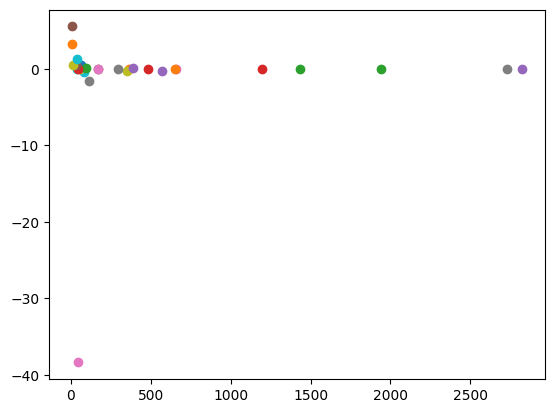

In [25]:
dups = [c for c in ttt['cluster'] if c+'_C' in ttt['cluster']]
for d in dups:
    j = np.argwhere(ttt['cluster'] == d)[0][0]
    k = np.argwhere(ttt['cluster'] == d+'_D')[0][0]
    l = np.argwhere(ttt['cluster'] == d+'_C')[0][0]
    huntage = ttt[j]['age']
    huntage_err = ttt[j]['e_age']
    diage = ttt[k]['age']
    diage_err = ttt[k]['e_age']
    crossage = ttt[l]['age']
    crossage_err = ttt[l]['e_age']
    # diff_err = np.sqrt(huntage_err**2 + diage_err**2)
    # tval = np.abs(huntage - diage) / diff_err
    wavg = (huntage/huntage_err**2 + diage/diage_err**2) / (1/huntage_err**2 + 1/diage_err**2)
    wavg_err = 1 / np.sqrt(1/huntage_err**2 + 1/diage_err**2)
    diff = wavg - crossage
    diff_err = np.sqrt(wavg_err**2 + crossage_err**2)
    tval = diff / diff_err
    rel_err = 100*(diff / crossage)
    plt.scatter(crossage,tval)
    # rel_err = 100*(abs(huntage - diage) / max(huntage,diage))
    # if rel_err > 10:
    #     print(f'{d}: {tval:.1f}')

In [4]:
## handle duplicates
comp_table = Table({'cluster':[],'age_hunt':[],'age_dias':[],'e_age_hunt':[],'e_age_dias':[],'[Fe/H]_hunt':[],'[Fe/H]_dias':[],'e_[Fe/H]_hunt':[],
                    'e_[Fe/H]_dias':[],'Av_hunt':[],'Av_dias':[],'e_Av_hunt':[],'e_Av_dias':[]},dtype=[str,float,float
                                      ,float,float,float,float,float,float,float,float,float,float])
for cluster in ttt['cluster']:
    if cluster.endswith('_D'):
        log1 = ttt[ttt['cluster'] == cluster[:-2]]['logage'][0]
        log2 = ttt[ttt['cluster'] == cluster]['logage'][0]
        e_log1 = ttt[ttt['cluster'] == cluster[:-2]]['e_logage'][0]
        e_log2 = ttt[ttt['cluster'] == cluster]['e_logage'][0]
        age1 = ttt[ttt['cluster'] == cluster[:-2]]['age'][0]
        age2 = ttt[ttt['cluster'] == cluster]['age'][0]
        e_age1 = ttt[ttt['cluster'] == cluster[:-2]]['e_age'][0]
        e_age2 = ttt[ttt['cluster'] == cluster]['e_age'][0]
        feh1 = ttt[ttt['cluster'] == cluster[:-2]]['[Fe/H]'][0]
        feh2 = ttt[ttt['cluster'] == cluster]['[Fe/H]'][0]
        e_feh1 = ttt[ttt['cluster'] == cluster[:-2]]['e_[Fe/H]'][0]
        e_feh2 = ttt[ttt['cluster'] == cluster]['e_[Fe/H]'][0]
        dist1 = ttt[ttt['cluster'] == cluster[:-2]]['Dist'][0]
        dist2 = ttt[ttt['cluster'] == cluster]['Dist'][0]
        e_dist1 = ttt[ttt['cluster'] == cluster[:-2]]['e_Dist'][0]
        e_dist2 = ttt[ttt['cluster'] == cluster]['e_Dist'][0]
        av1 = ttt[ttt['cluster'] == cluster[:-2]]['Av'][0]
        av2 = ttt[ttt['cluster'] == cluster]['Av'][0]
        e_av1 = ttt[ttt['cluster'] == cluster[:-2]]['e_Av'][0]
        e_av2 = ttt[ttt['cluster'] == cluster]['e_Av'][0]

        comp_table.add_row([cluster[:-2],age1,age2,e_age1,e_age2,feh1,feh2,e_feh1,e_feh2,av1,av2,e_av1,e_av2])
        
        # if (abs(age1-age2) / (e_age1**2 + e_age2**2)**0.5 > 3) or (abs(av1-av2)/(e_av1**2 + e_av2**2)**0.5 > 3):
        #     print('Cluster '+cluster+' has inconsistent results')
        #     print('Please manually inspect the best fit plots and decide which result to keep')
        #     print('Text Oren please :)')
        #     break
        
        # ttt.remove_row(np.where(ttt['cluster'] == cluster)[0][0])
        # idx = np.where(ttt['cluster'] == cluster[:-2])[0][0]
        # ttt[idx]['logage'] = (log1/e_log1**2 + log2/e_log2**2) / (1/e_log1**2 + 1/e_log2**2)
        # ttt[idx]['e_logage'] = (e_log1**(-2) + e_log2**(-2))**(-0.5)
        # ttt[idx]['age'] = (age1/e_age1**2 + age2/e_age2**2) / (1/e_age1**2 + 1/e_age2**2)
        # ttt[idx]['e_age'] = (e_age1**(-2) + e_age2**(-2))**(-0.5)
        # ttt[idx]['[Fe/H]'] = (feh1/e_feh1**2 + feh2/e_feh2**2) / (1/e_feh1**2 + 1/e_feh2**2)
        # ttt[idx]['e_[Fe/H]'] = (e_feh1**(-2) + e_feh2**(-2))**(-0.5)
        # ttt[idx]['Dist'] = (dist1/e_dist1**2 + dist2/e_dist2**2) / (1/e_dist1**2 + 1/e_dist2**2)
        # ttt[idx]['e_Dist'] = (e_dist1**(-2) + e_dist2**(-2))**(-0.5)
        # ttt[idx]['Av'] = (av1/e_av1**2 + av2/e_av2**2) / (1/e_av1**2 + 1/e_av2**2)
        # ttt[idx]['e_Av'] = (e_av1**(-2) + e_av2**(-2))**(-0.5)


In [44]:
%matplotlib tk
# fig,ax = plt.subplots(nrows=1,ncols=3,dpi=300,layout='constrained',figsize=(12,4))
fig,ax = plt.subplots(nrows=1,ncols=1,dpi=300)

tblc = np.isin(comp_table['cluster'],['Collinder_463','NGC_6991','NGC_6208','UPK_51'])

ax.scatter(comp_table['age_hunt'],comp_table['age_dias'],c='k',s=25,zorder=2)
ax.scatter(comp_table['age_hunt'][tblc],comp_table['age_dias'][tblc],c='b',s=100,zorder=5)
ax.plot(np.sort(comp_table['age_hunt']),np.sort(comp_table['age_hunt']),color='red',linestyle='--',lw=1,zorder=0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Age Hunt (Myr)',labelpad=0,fontsize=14)
ax.set_ylabel('Age Dias (Myr)',labelpad=0,fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.minorticks_on()

# ax[1].scatter(comp_table['[Fe/H]_hunt'],comp_table['[Fe/H]_dias'],c='k',s=25,zorder=2)
# ax[1].scatter(comp_table['[Fe/H]_hunt'][tblc],comp_table['[Fe/H]_dias'][tblc],c='b',s=100,zorder=5)
# ax[1].plot(np.sort(comp_table['[Fe/H]_hunt']),np.sort(comp_table['[Fe/H]_hunt']),color='red',linestyle='--',lw=1,zorder=0)
# ax[1].set_xlabel('[Fe/H] Hunt (dex)',labelpad=0)
# ax[1].set_ylabel('[Fe/H] Dias (dex)',labelpad=0)
# # ax[1].minorticks_on()

# ax[2].scatter(comp_table['Av_hunt'],comp_table['Av_dias'],c='k',s=25,zorder=2)
# ax[2].scatter(comp_table['Av_hunt'][tblc],comp_table['Av_dias'][tblc],c='b',s=100,zorder=5)
# ax[2].plot(np.sort(comp_table['Av_hunt']),np.sort(comp_table['Av_hunt']),color='red',linestyle='--',lw=1,zorder=0)
# ax[2].set_xlabel('$A_V$ Hunt (mag)',labelpad=0)
# ax[2].set_ylabel('$A_V$ Dias (mag)',labelpad=0)
# ax[2].minorticks_on()

fig.savefig('cluster_comp.png',bbox_inches='tight')

In [4]:
## add results to table_B

t = Table.read('table_B.fits')
t['age'] = np.full(len(t), np.nan)
t['e_age'] = np.full(len(t), np.nan)
t['[Fe/H]'] = np.full(len(t), np.nan)
t['e_[Fe/H]'] = np.full(len(t), np.nan)
t['Av'] = np.full(len(t), np.nan)
t['e_Av'] = np.full(len(t), np.nan)

for clstr in t['cluster']:
    if clstr.startswith('[b'):
        idx = np.where(t['cluster'] == clstr)[0][0]
        clstr = clstr[3:-2]
        t['cluster'][idx] = clstr
    if clstr in ttt['cluster']:
        idx = np.where(ttt['cluster'] == clstr)[0][0]
        t['age'][t['cluster'] == clstr] = ttt['age'][idx]
        t['e_age'][t['cluster'] == clstr] = ttt['e_age'][idx]
        t['[Fe/H]'][t['cluster'] == clstr] = ttt['[Fe/H]'][idx]
        t['e_[Fe/H]'][t['cluster'] == clstr] = ttt['e_[Fe/H]'][idx]
        t['Av'][t['cluster'] == clstr] = ttt['Av'][idx]
        t['e_Av'][t['cluster'] == clstr] = ttt['e_Av'][idx]

In [ ]:
## sort columns by importance, print table_B to check everything is ok before overwriting file
t['idx'] = np.arange(len(t))
cols = t.colnames
first_cols = ['idx','source_id','Pmemb','cluster','ra','dec','parallax','parallax_error','mg','phot_g_mean_mag','bp_rp','age','e_age','[Fe/H]','e_[Fe/H]','Av','e_Av','period','nuv_mag']
for c in first_cols:
    cols.remove(c)
cols = first_cols + cols
t = t[cols]

t.show_in_notebook(display_length=20)

In [17]:
## save table_B

t.write('table_B.fits', format='fits',overwrite=True)

# Cluster association

In [ ]:
# ## cluster association verification

# %matplotlib tk
# sources = Table.read('table_C.fits')

# idx = 261
# j = np.where(sources['idx'] == idx)[0][0]
# cluster = sources['cluster'][j]

# membs = Table(np.genfromtxt(os.path.join('OCFit','gaiaDR2','data',cluster+'.dat'),dtype=None,names=True,encoding=None,delimiter=','))

# k = np.where([membs['source_id'] == sources['source_id'][j]])[1][0]


# id_lst = membs['source_id']

# # Get the data from Gaia
# query1 = f'''SELECT * FROM gaiadr3.gaia_source WHERE source_id IN {tuple(id_lst)}'''
# job1 = Gaia.launch_job(query1)
# res1 = job1.get_results()

# # Get the data from NSS
# query2 = f'''SELECT * FROM gaiadr3.nss_two_body_orbit WHERE source_id = {sources['source_id'][j]}'''
# job2 = Gaia.launch_job(query2)
# res2 = job2.get_results()


# u = np.where(res1['SOURCE_ID'] == sources['source_id'][j])[0][0]
# v = np.where(res2['SOURCE_ID'] == sources['source_id'][j])[0][0]


# pmra_cluster = res1['pmra']
# pmra_obj = pmra_cluster[u]
# pmra_nss = res2[v]['pmra']
# pmra_err = np.sqrt(res1[u]['pmra_error']**2+res2[v]['pmra_error']**2)

# parallax_cluster = res1['parallax']
# parallax_obj = parallax_cluster[u]
# parallax_nss = res2[v]['parallax']
# parallax_err = np.sqrt(res1[u]['parallax_error']**2 + res2[v]['parallax_error']**2)

# pmdec_cluster = res1['pmdec']
# pmdec_obj = pmdec_cluster[u]
# pmdec_nss = res2[v]['pmdec']
# pmdec_err = np.sqrt(res1[u]['pmdec_error']**2 + res2[v]['pmdec_error']**2)

# sigma_pmra = abs(pmra_cluster.mean() - pmra_nss)/pmra_cluster.std()
# sigma_pmdec = abs(pmdec_cluster.mean() - pmdec_nss)/pmdec_cluster.std()
# sigma_parallax = abs(parallax_cluster.mean() - parallax_nss)/parallax_cluster.std()
# sigma_rv = abs(res1['radial_velocity'].mean() - sources[j]['radial_velocity'])/res1['radial_velocity'].std()

# w = np.argsort([0,0,sigma_pmra,sigma_pmdec,sigma_parallax])[2:]

# if 0 in w:
#     ''
# if 1 in w:
#     ''
# if 2 in w:
#     fig, ax = plt.subplots()
#     ax.hist(pmra_cluster, bins=10)
#     ax.axvline(pmra_obj, color='r', label='DR3')
#     ax.axvline(pmra_nss, color='b', label='NSS')
#     ax.set_xlabel('Proper Motion RA')
#     ax.set_title(f'{cluster} - {sources[j]["idx"]}')
#     ax.legend()
#     plt.show()
# if 3 in w:
#     fig, ax = plt.subplots()
#     ax.hist(pmdec_cluster, bins=10)
#     ax.axvline(pmdec_obj, color='r', label='DR3')
#     ax.axvline(pmdec_nss, color='b', label='NSS')
#     ax.set_xlabel('Proper Motion Dec')
#     ax.set_title(f'{cluster} - {sources[j]["idx"]}')
#     ax.legend()
#     plt.show()
# if 4 in w:
#     fig, ax = plt.subplots()
#     ax.hist(parallax_cluster, bins=10)
#     ax.axvline(parallax_obj, color='r', label='DR3')
#     ax.axvline(parallax_nss, color='b', label='NSS')
#     ax.set_xlabel('Parallax')
#     ax.set_title(f'{cluster} - {sources[j]["idx"]}')
#     ax.legend()
#     plt.show()